In [45]:
import numpy as np
import pandas as pd
from sklearn import tree
import copy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

#Load Data

In [46]:
from sklearn import datasets

data = datasets.fetch_california_housing(as_frame=True)

In [47]:
print(data)

{'data':        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  
0        -1

In [48]:
X = data.data

In [49]:
print(X)

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  
0        -122.23  
1

In [50]:
y = data.target
print(y)

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64


In [51]:
final_df = pd.concat([X, y], axis = 1)

#Functions

In [52]:
#in case dummy variables need to be created. Not necessary with this dataset
def dummy_variables(df, prefix_names, col_names):
  dummies = []
  for i in range(len(prefix_names)):
    dummy = pd.get_dummies(df[col_names[i]], prefix = prefix_names[i])
    dummies.append(dummy)
  return dummies

#To reverse dummy variables, e.g. if you want to create a generalised table
#to be used to create prediction values for specific output
def reverse_dummy_variables(dummies, prefix_names, col_names, original_df):
    original_values = []

    # Extract other integer columns from the original DataFrame
    integer_columns = original_df.select_dtypes(include=['int', 'int64', 'float']).copy()

    for i in range(len(dummies)):
        # Extract the prefix for the current set of dummies
        prefix = prefix_names[i]

        # Get the columns that match the prefix
        matching_columns = [col for col in dummies[i].columns if col.startswith(prefix)]

        # Combine the matching columns to get the original variable
        original_value = dummies[i][matching_columns].idxmax(axis=1).str.replace(prefix + "_", "")
        original_values.append(original_value)

    # Create a DataFrame with the original values
    original_df = pd.DataFrame({col_names[i]: original_values[i] for i in range(len(original_values))})

    # Combine the original values with other integer columns
    combined_df = pd.concat([original_df, integer_columns], axis=1)

    return combined_df

#Train random forest model
def train_randomForest(X, y): #X = X_train, y = y_train
  n_features = X.shape[1]
  max_features_sqrt = int(np.sqrt(n_features))

# Tree controlls for RF
  rfr_settings = {'oob_score': True,
                  'max_features': max_features_sqrt,
                  'random_state': 1,
                  'warm_start': True}

# loop over B estimators, basically increase number of trees to compare OOB error
  #B = np.arange(15, 200, 1)
  rfr = RandomForestRegressor().set_params(**rfr_settings)
  error_rfr = []
  #for b in B:
  # Grow and fit tree
  b=100
  rfr.set_params(n_estimators=b)
  rfr.fit(X, y)
  error_rfr.append(1 - rfr.oob_score_)
  return rfr, error_rfr

#Dataframe of feature importance
def get_feature_importance(X, model):
  FI = pd.DataFrame(data={'Feature': X.columns.values, 'Importance': model.feature_importances_})
  return FI

#For the metrics that we need
def adjusted_r2_score(r2, n_samples, n_features):
  return 1 - (1 - r2) * ((n_samples - 1) / (n_samples - n_features - 1))

#As an output we get a dataset of the metrics
def evaluate_model(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, model, error_rf):
#get MSE
  train_mse = mean_squared_error(y_train, y_train_pred)
  test_mse = mean_squared_error(y_test, y_test_pred)


  # Mean Absolute Error (MAE)
  train_mae = mean_absolute_error(y_train, y_train_pred)
  test_mae = mean_absolute_error(y_test, y_test_pred)


  #RMSE
  train_rmse = np.sqrt(train_mse)
  test_rmse = np.sqrt(test_mse)


  #R-squared
  train_r2 = r2_score(y_train, y_train_pred)
  test_r2 = r2_score(y_test, y_test_pred)


  #adjusted R-squared
  n_samples_train, n_features = X_train.shape
  n_samples_test = X_test.shape[0]


  train_adjusted_r2 = adjusted_r2_score(train_r2, n_samples_train, n_features)
  test_adjusted_r2 = adjusted_r2_score(test_r2, n_samples_test, n_features)


  metrics = {
      'MSE': [train_mse, test_mse],
      'MAE': [train_mae, test_mae],
      'RMSE': [train_rmse, test_rmse],
      'R-squared': [train_r2, test_r2],
      'Adjusted R-squared': [train_adjusted_r2, test_adjusted_r2],
      'OOB-Error': [error_rf[0], 0]
  }


  results_df = pd.DataFrame(metrics, index=['Train', 'Test'])

  return results_df

#Transform data

- e.g. create dummy variables - not the case here
- remove NA values - not the case here
- large deltas between max and min values

In [53]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Can see these values have a large difference between the min and max value:
- MedInc
- HouseAge
- AveRooms
- AveBedrms
- Population
- AveOccup

Next I will plot the histograms of these variables:

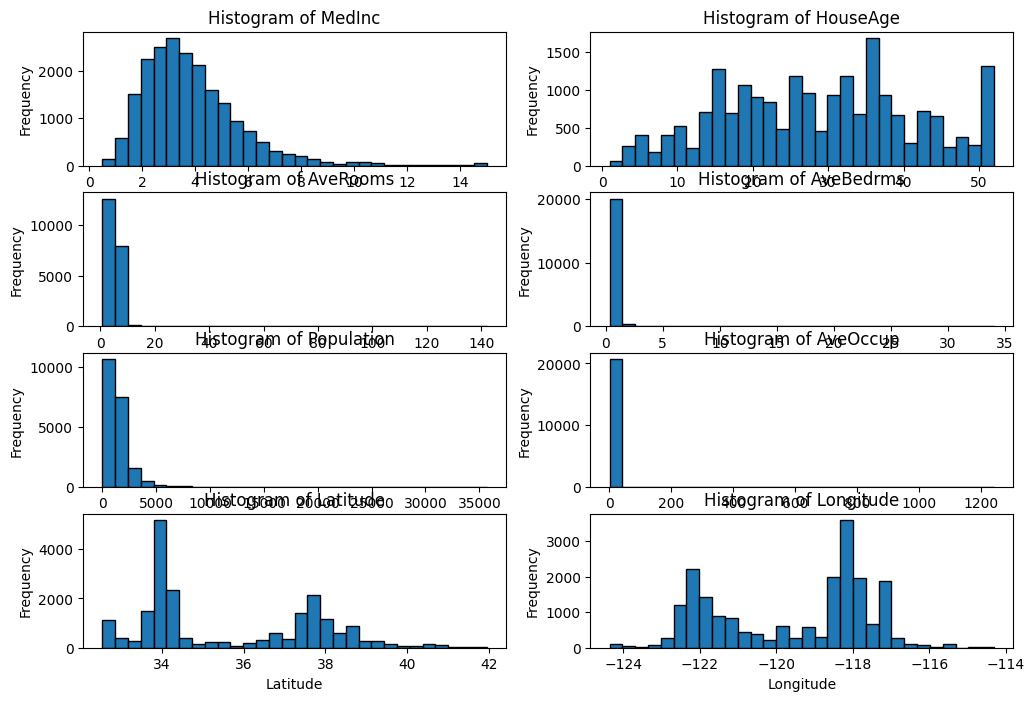

In [54]:

fig, axes = plt.subplots(nrows=len(X.columns) // 2, ncols=2, figsize=(12, 2 * len(X.columns) // 2))

for i, column in enumerate(X.columns):
  row = i//2
  col = i% 2
  axes[row, col].hist(X[column], bins=30, edgecolor='black')
  axes[row, col].set_title(f'Histogram of {column}')
  axes[row, col].set_xlabel(column)
  axes[row, col].set_ylabel('Frequency')
plt.show()

- AveRooms/AveBedrms have a large tail
- AveOccup and Population have a large tail
- Medinc appears to have quite a large outlier on the right side, but with further investigation it's multiple outliers. For now I will leave this column as is, but depending on outcome, transformation might make sense here as well.


In [55]:
X["logPopulation"]= np.log(X["Population"])
X["logAveOccup"] = np.log(X["AveOccup"])


In [56]:
print(X[X["MedInc"]> 14])

        MedInc  HouseAge   AveRooms  AveBedrms  Population   AveOccup  \
1566   15.0001       2.0  22.222222   2.222222        25.0   2.777778   
4352   15.0001      37.0   8.659574   1.425532       100.0   2.127660   
4604   15.0001      52.0   8.444954   1.100917       693.0   3.178899   
4605   15.0001      52.0   8.483019   0.962264       813.0   3.067925   
4606   15.0001      52.0   9.204969   1.062112       531.0   3.298137   
4626   15.0001      52.0   7.958333   0.833333       457.0   3.808333   
4678   15.0001      52.0   8.780612   0.994898       688.0   3.510204   
5242   15.0001      32.0   8.002869   1.080344      1567.0   2.248207   
5247   15.0001      36.0   9.368263   1.173653       862.0   2.580838   
5248   15.0001      46.0   8.365591   0.967742       238.0   2.559140   
5257   15.0001      42.0   9.229032   1.161290       829.0   2.674194   
5260   15.0000      39.0   9.293750   1.018750       414.0   2.587500   
5275   15.0001      36.0   7.549091   0.985455     

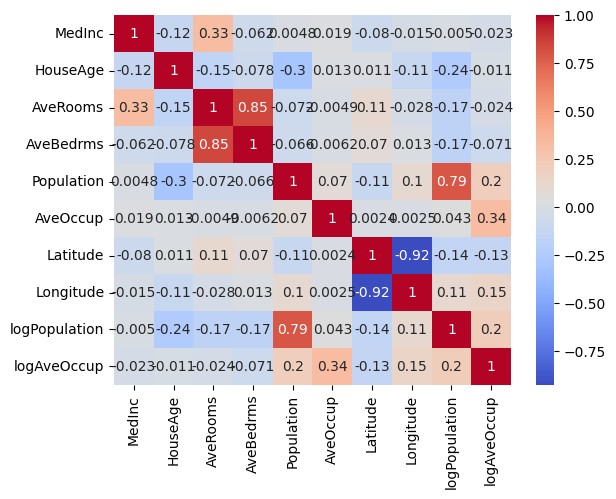

In [57]:
import seaborn as sns

correlation_matrix = X.corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

Average rooms and average bedrooms have a high correlation. In this case I will remove AveBedrms and AveRooms in 2 different datasets and see which model performs better.

## Plot Langitute vs Longitude

- we can assume these variables could be somehow combined since they give us information of the location of the blocks.

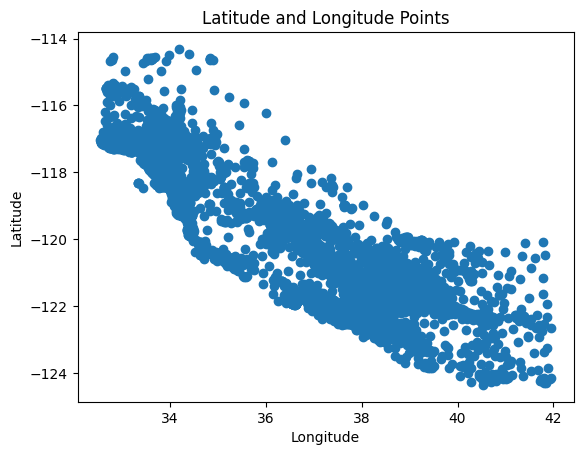

In [58]:
plt.scatter(X["Latitude"], X["Longitude"])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Latitude and Longitude Points")
plt.show()

It's actually interesting, here we can see that the data points actually take the shape of the california coast line.

I believe we will be able to observe that houses near the coast have a higher price point than houses that are more inland.

In [59]:
print(X)

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  logPopulation  logAve

In [60]:
X = X.drop(["Population"], axis = 1)
X = X.drop(["AveOccup"], axis = 1)

X1 = X.drop(["AveBedrms"], axis =1)
X2 = X.drop(["AveRooms"], axis = 1)

print(X1)
print(X2)

       MedInc  HouseAge  AveRooms  Latitude  Longitude  logPopulation  \
0      8.3252      41.0  6.984127     37.88    -122.23       5.774552   
1      8.3014      21.0  6.238137     37.86    -122.22       7.783641   
2      7.2574      52.0  8.288136     37.85    -122.24       6.206576   
3      5.6431      52.0  5.817352     37.85    -122.25       6.324359   
4      3.8462      52.0  6.281853     37.85    -122.25       6.336826   
...       ...       ...       ...       ...        ...            ...   
20635  1.5603      25.0  5.045455     39.48    -121.09       6.739337   
20636  2.5568      18.0  6.114035     39.49    -121.21       5.874931   
20637  1.7000      17.0  5.205543     39.43    -121.22       6.914731   
20638  1.8672      18.0  5.329513     39.43    -121.32       6.608001   
20639  2.3886      16.0  5.254717     39.37    -121.24       7.234898   

       logAveOccup  
0         0.938270  
1         0.746613  
2         1.030426  
3         0.935287  
4         0.779998

#Create Train and Test dataset

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)


X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

#Train Random Forest Model

In [62]:
rf, error_rf = train_randomForest(X_train, y_train)

rf2, error_rf2 = train_randomForest(X2_train, y2_train)

In [63]:
FI = get_feature_importance(X1, rf)
FI2 = get_feature_importance(X2, rf2)

In [64]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)


#get table with results to evaluate model
results_df= evaluate_model(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, rf, error_rf)


y_train_pred2 = rf2.predict(X2_train)
y_test_pred2 = rf2.predict(X2_test)


#get table with results to evaluate model
results_df2= evaluate_model(X2_train, X2_test, y2_train, y2_test, y_train_pred2, y_test_pred2, rf2, error_rf2)


In [65]:
print(results_df)

            MSE       MAE      RMSE  R-squared  Adjusted R-squared  OOB-Error
Train  0.032693  0.119206  0.180812   0.975544            0.975533   0.177804
Test   0.233264  0.316975  0.482974   0.821991            0.821689   0.000000


In [66]:
print(results_df2)

            MSE       MAE      RMSE  R-squared  Adjusted R-squared  OOB-Error
Train  0.033198  0.120458  0.182204   0.975165            0.975155   0.180133
Test   0.239679  0.322331  0.489571   0.817096            0.816785   0.000000


For both when looking at the adjusted R-squared it appears that the model is overfitting slightly on the training data.

In [68]:
final_df["PredictedValue"] = rf.predict(X1)
final_df["PredictedValue2"] =rf2.predict(X2)

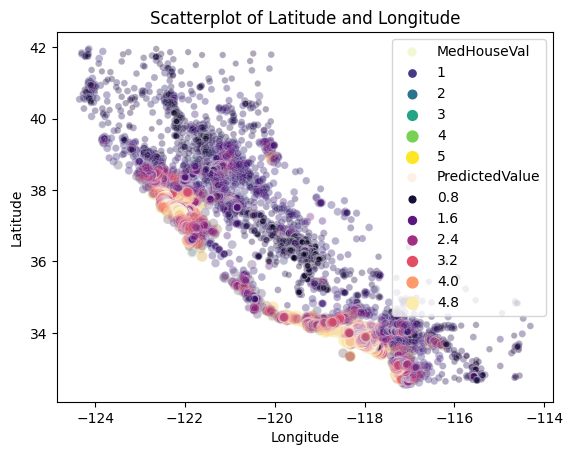

In [73]:
sns.scatterplot(
    data = final_df,
    x = "Longitude",
    y = "Latitude",
    hue = "MedHouseVal",
    size = "MedHouseVal",
    palette = "viridis",
    alpha = 0.2,
    label = "MedHouseVal"
)

sns.scatterplot(
    data = final_df,
    x = "Longitude",
    y = "Latitude",
    hue = "PredictedValue",
    size = "PredictedValue",
    palette = "magma",
    alpha = 0.2,
    label = "PredictedValue"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatterplot of Latitude and Longitude")
plt.legend()
plt.show()

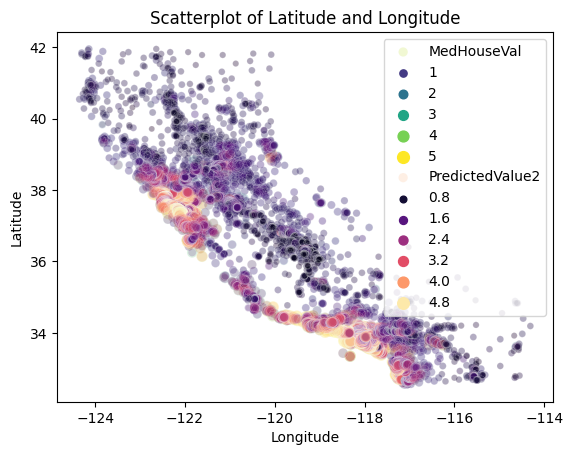

In [74]:
sns.scatterplot(
    data = final_df,
    x = "Longitude",
    y = "Latitude",
    hue = "MedHouseVal",
    size = "MedHouseVal",
    palette = "viridis",
    alpha = 0.2,
    label = "MedHouseVal"
)

sns.scatterplot(
    data = final_df,
    x = "Longitude",
    y = "Latitude",
    hue = "PredictedValue2",
    size = "PredictedValue2",
    palette = "magma",
    alpha = 0.2,
    label = "PredictedValue2"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatterplot of Latitude and Longitude")
plt.legend()
plt.show()

##Look at Feature importance:

In [75]:
print(FI)

         Feature  Importance
0         MedInc    0.367862
1       HouseAge    0.058717
2       AveRooms    0.116229
3       Latitude    0.144923
4      Longitude    0.144981
5  logPopulation    0.039452
6    logAveOccup    0.127835


In [76]:
X3 = X.drop(["HouseAge"], axis =1)
X3 = X3.drop(["logPopulation"], axis = 1)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

rf3, error_rf3 = train_randomForest(X3_train, y3_train)

y_train_pred3 = rf3.predict(X3_train)
y_test_pred3 = rf3.predict(X3_test)


#get table with results to evaluate model
results_df3 = evaluate_model(X3_train, X3_test, y3_train, y3_test, y_train_pred3, y_test_pred3, rf3, error_rf3)

print(results_df3)

            MSE       MAE      RMSE  R-squared  Adjusted R-squared  OOB-Error
Train  0.034077  0.120783  0.184601   0.974508            0.974499    0.18476
Test   0.245690  0.323707  0.495672   0.812509            0.812236    0.00000


Removing the features with low importance don't make much of a difference.

#Look at decision tree:

In [77]:
from sklearn.tree import plot_tree

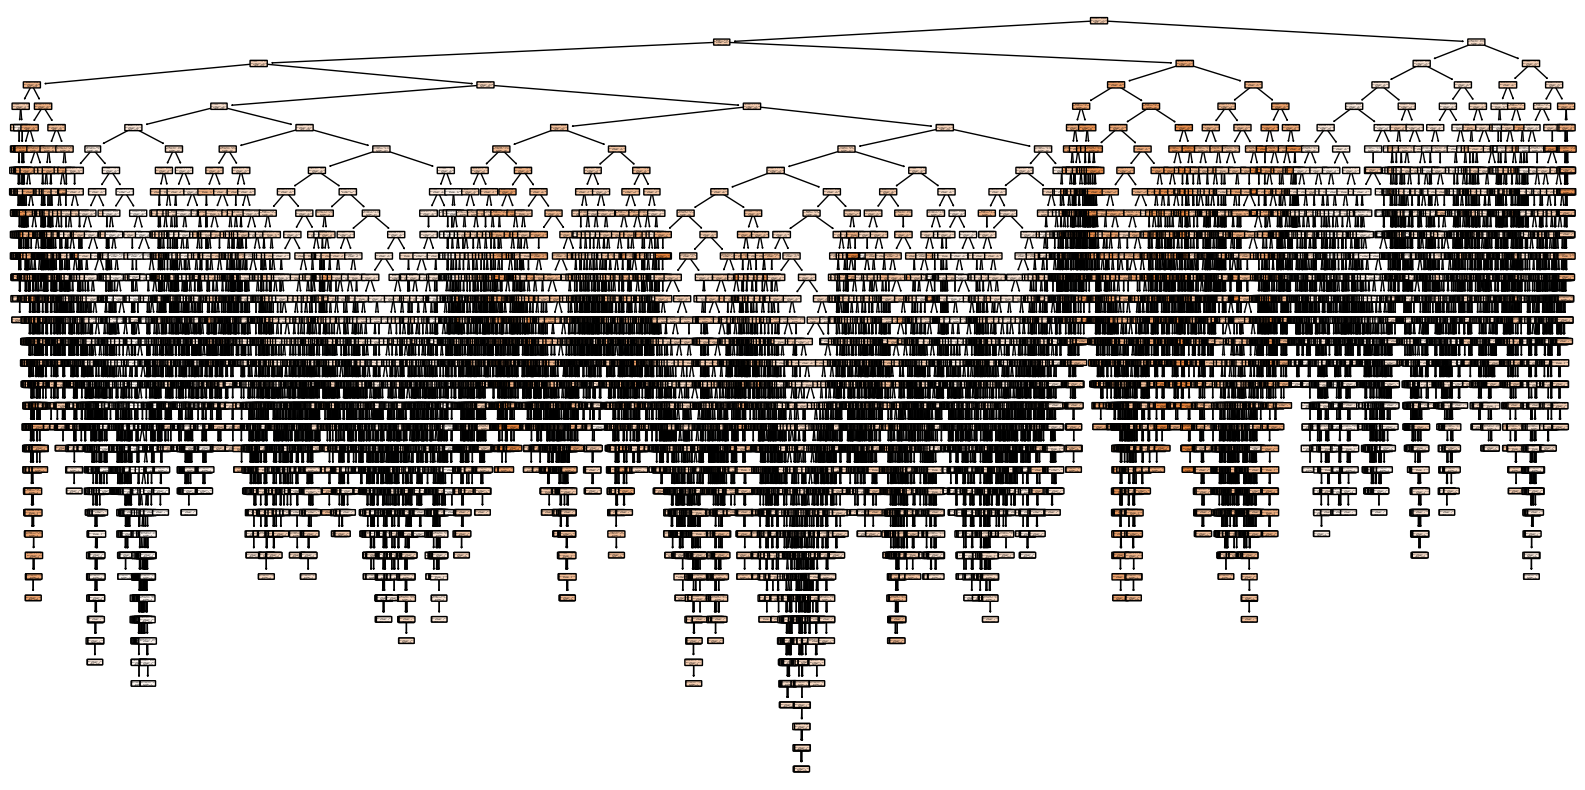

In [78]:
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=X1.columns, filled=True, rounded=True)
plt.show()